In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train"
new_test = "./new_val_in"



# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)
val_testset  = ArgoverseDataset(data_path=new_test)

In [3]:
batch_sz = 4
batch_sz_test = 1
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=0)


In [4]:
def my_collate1(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    scene_idx = [numpy.dstack([scene['scene_idx']]) for scene in batch]
    inp = torch.FloatTensor(inp)
    return scene_idx, inp

test_loader = DataLoader(val_testset, batch_size=batch_sz_test, shuffle=False, collate_fn=my_collate1)

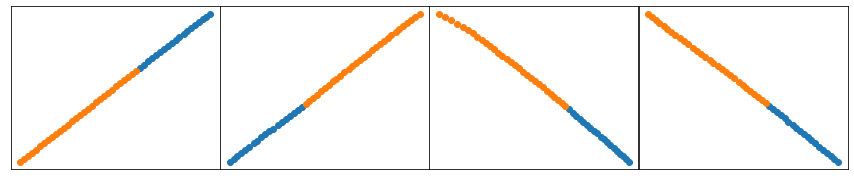

In [5]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    show_sample_batch(sample_batch, agent_id)
    break

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class FCModule(nn.Module):
    
    def __init__(self):
        super(FCModule, self).__init__()
        
        self.hidden_dim = 15000
        self.linear2 = nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(240*19, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, 240*25),
                                     nn.ReLU(),
                                     nn.Linear(240*25, 240*30))
        
        

    def forward(self, x):
        x = self.linear2(x)
        
        return x
    
    def forward_test(self, x, num_steps = 30):
        res=[]
        h = torch.zeros((self.num_layers,len(x),self.hidden_dim)).cuda()
        c = torch.zeros((self.num_layers,len(x),self.hidden_dim)).cuda()
        for step in range(num_steps):
            x, (h,c) = self.lstm(x, (h,c))
            x = x[:,-1:]
            x = x.transpose(1,2)
            x = self.linear(x)
            x = x.transpose(1,2)
            res.append(x)
        res = torch.cat(res,1)
        return res

In [7]:
from tqdm import tqdm_notebook as tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda:0"
model = FCModule().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

loss_ema = -1
loss_ema2 = -1

#loss array
loss_array = []
loss_ema_array = []

for epoch in range(1):
    for i_batch, sample_batch in enumerate (val_loader):
        inp,out = sample_batch
        inp = inp.cuda()
        out = out.cuda()
        mixed = torch.cat([inp,out],2).transpose(1,2).reshape(-1,49,240)
        y_pred = model(inp.reshape(len(inp),-1)).reshape(-1,60,30,4)
        loss = (torch.mean((y_pred-out)**2))**0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss_ema < 0:
            loss_ema = loss
        loss_ema = loss_ema*0.99 + loss*0.01
        
         #loss array
        loss_array.append(loss.item())
        loss_ema_array.append(loss_ema.item())
        
        if i_batch%10 == 0:
            print('loss full', epoch, i_batch, loss_ema.item(), loss.item())
torch.save(model.state_dict(),"usingSequential")

loss full 0 0 563.3839721679688 563.3839721679688
loss full 0 10 593.8030395507812 549.5331420898438
loss full 0 20 580.487060546875 497.6867370605469
loss full 0 30 553.2130126953125 197.7635040283203
loss full 0 40 521.0549926757812 200.48814392089844
loss full 0 50 494.505126953125 337.38812255859375
loss full 0 60 470.9853820800781 204.46592712402344
loss full 0 70 447.46502685546875 188.2219696044922
loss full 0 80 432.6944274902344 554.4177856445312
loss full 0 90 415.95770263671875 382.33050537109375
loss full 0 100 398.65673828125 352.1223449707031
loss full 0 110 387.76580810546875 125.75862121582031
loss full 0 120 369.09796142578125 180.47994995117188
loss full 0 130 352.1966552734375 192.9466094970703
loss full 0 140 340.5419616699219 226.79934692382812
loss full 0 150 327.2124938964844 360.70819091796875
loss full 0 160 315.15997314453125 169.02244567871094
loss full 0 170 312.6262512207031 233.96224975585938
loss full 0 180 299.4878234863281 212.93621826171875
loss full 0

loss full 0 1550 85.99138641357422 48.832275390625
loss full 0 1560 85.18988800048828 87.03914642333984
loss full 0 1570 83.79842376708984 101.79966735839844
loss full 0 1580 83.23619842529297 89.91960144042969
loss full 0 1590 83.16815948486328 38.533485412597656
loss full 0 1600 84.94747924804688 53.00621032714844
loss full 0 1610 84.240234375 72.30094146728516
loss full 0 1620 84.86901092529297 67.05712127685547
loss full 0 1630 84.14185333251953 93.24089050292969
loss full 0 1640 84.5315933227539 95.33343505859375
loss full 0 1650 84.35335540771484 80.2059326171875
loss full 0 1660 86.90678405761719 77.74040985107422
loss full 0 1670 85.36751556396484 66.33875274658203
loss full 0 1680 84.33595275878906 53.12825012207031
loss full 0 1690 84.1147232055664 111.45460510253906
loss full 0 1700 85.74705505371094 58.84916687011719
loss full 0 1710 85.88545227050781 82.3935775756836
loss full 0 1720 85.77259063720703 137.95974731445312
loss full 0 1730 84.22199249267578 47.43638610839844


loss full 0 3100 60.722408294677734 52.099510192871094
loss full 0 3110 60.734336853027344 39.74665069580078
loss full 0 3120 60.86677169799805 77.35186004638672
loss full 0 3130 59.8737678527832 37.69725036621094
loss full 0 3140 60.35588073730469 44.775760650634766
loss full 0 3150 59.72669219970703 57.964141845703125
loss full 0 3160 60.42193603515625 61.70677185058594
loss full 0 3170 62.33024215698242 76.60908508300781
loss full 0 3180 61.36426544189453 44.31162643432617
loss full 0 3190 62.145973205566406 107.40132904052734
loss full 0 3200 60.08390808105469 37.884708404541016
loss full 0 3210 61.02845764160156 42.91386413574219
loss full 0 3220 61.19217300415039 65.26844024658203
loss full 0 3230 60.9348258972168 73.18423461914062
loss full 0 3240 61.79889678955078 100.09026336669922
loss full 0 3250 61.397789001464844 45.54709243774414
loss full 0 3260 59.83091735839844 52.55290985107422
loss full 0 3270 58.68041229248047 42.77044677734375
loss full 0 3280 59.98611068725586 94.

loss full 0 4640 57.241397857666016 45.915374755859375
loss full 0 4650 56.60087966918945 36.31719970703125
loss full 0 4660 54.79753112792969 40.193275451660156
loss full 0 4670 53.76190948486328 29.096786499023438
loss full 0 4680 52.959068298339844 36.09659957885742
loss full 0 4690 56.063106536865234 47.07832336425781
loss full 0 4700 57.427974700927734 33.307647705078125
loss full 0 4710 57.9667854309082 74.15657043457031
loss full 0 4720 57.594627380371094 51.22129821777344
loss full 0 4730 56.2331428527832 59.095664978027344
loss full 0 4740 56.377681732177734 46.100608825683594
loss full 0 4750 56.26239776611328 35.24197006225586
loss full 0 4760 55.58047103881836 53.91454315185547
loss full 0 4770 56.635169982910156 79.41722869873047
loss full 0 4780 55.51338577270508 45.41526412963867
loss full 0 4790 54.63888931274414 32.456146240234375
loss full 0 4800 55.326900482177734 61.098175048828125
loss full 0 4810 54.48680877685547 57.00802230834961
loss full 0 4820 54.344444274902

loss full 0 6180 44.453338623046875 37.40200424194336
loss full 0 6190 44.68499755859375 43.89034652709961
loss full 0 6200 45.32732009887695 79.88484191894531
loss full 0 6210 45.38935470581055 48.078102111816406
loss full 0 6220 45.757545471191406 32.76112747192383
loss full 0 6230 45.08129119873047 34.602603912353516
loss full 0 6240 46.76557159423828 28.778419494628906
loss full 0 6250 47.97701644897461 45.07069396972656
loss full 0 6260 47.574188232421875 75.78501892089844
loss full 0 6270 46.365928649902344 27.555065155029297
loss full 0 6280 46.16339111328125 39.449615478515625
loss full 0 6290 45.46668243408203 55.49913787841797
loss full 0 6300 45.943084716796875 40.441131591796875
loss full 0 6310 44.96548843383789 32.42858123779297
loss full 0 6320 46.086936950683594 33.94472122192383
loss full 0 6330 47.27716827392578 24.912593841552734
loss full 0 6340 48.60565185546875 198.2541961669922
loss full 0 6350 49.698516845703125 64.15918731689453
loss full 0 6360 48.644882202148

loss full 0 7710 49.77273941040039 32.400108337402344
loss full 0 7720 49.95565414428711 28.364381790161133
loss full 0 7730 51.56300354003906 32.91405487060547
loss full 0 7740 50.94072723388672 61.09346389770508
loss full 0 7750 49.53956985473633 46.85622024536133
loss full 0 7760 51.50446701049805 26.560829162597656
loss full 0 7770 50.8376350402832 37.00247573852539
loss full 0 7780 50.124141693115234 30.10354995727539
loss full 0 7790 52.14643096923828 73.42961120605469
loss full 0 7800 53.63462448120117 54.20783233642578
loss full 0 7810 52.97372055053711 45.09436798095703
loss full 0 7820 52.500282287597656 31.2855281829834
loss full 0 7830 51.63956832885742 29.424556732177734
loss full 0 7840 52.60193634033203 46.703250885009766
loss full 0 7850 51.854679107666016 48.459529876708984
loss full 0 7860 50.84907913208008 35.90567398071289
loss full 0 7870 53.08341979980469 301.12127685546875
loss full 0 7880 51.954994201660156 31.7259464263916
loss full 0 7890 50.371925354003906 24

loss full 0 9250 49.34276580810547 93.27582550048828
loss full 0 9260 48.4451789855957 36.75224685668945
loss full 0 9270 47.9781494140625 52.113311767578125
loss full 0 9280 46.997589111328125 33.85251998901367
loss full 0 9290 46.66581726074219 42.38154602050781
loss full 0 9300 45.693843841552734 39.978084564208984
loss full 0 9310 46.54615783691406 48.57193374633789
loss full 0 9320 47.93285369873047 34.163116455078125
loss full 0 9330 48.37021255493164 28.861574172973633
loss full 0 9340 47.729881286621094 71.03771209716797
loss full 0 9350 47.020484924316406 28.004528045654297
loss full 0 9360 46.61868667602539 52.5311164855957
loss full 0 9370 45.85755920410156 61.13520050048828
loss full 0 9380 45.5711555480957 20.602392196655273
loss full 0 9390 45.528907775878906 45.0095100402832
loss full 0 9400 44.896488189697266 29.13840675354004
loss full 0 9410 43.5236930847168 22.661874771118164
loss full 0 9420 43.25426483154297 24.158388137817383
loss full 0 9430 43.727569580078125 69

loss full 0 10770 41.755889892578125 30.650243759155273
loss full 0 10780 42.24271774291992 24.519954681396484
loss full 0 10790 43.53500747680664 45.663970947265625
loss full 0 10800 43.25490951538086 23.681896209716797
loss full 0 10810 42.29788589477539 31.642255783081055
loss full 0 10820 44.35677719116211 42.305419921875
loss full 0 10830 43.98586654663086 17.96507453918457
loss full 0 10840 44.32040023803711 51.44675064086914
loss full 0 10850 43.2801628112793 30.23008918762207
loss full 0 10860 43.43901443481445 51.605201721191406
loss full 0 10870 43.146244049072266 41.01256561279297
loss full 0 10880 42.43501663208008 33.190006256103516
loss full 0 10890 43.62532424926758 47.55575180053711
loss full 0 10900 43.678348541259766 30.200719833374023
loss full 0 10910 43.70517349243164 33.11411666870117
loss full 0 10920 42.97407150268555 44.40829086303711
loss full 0 10930 42.641944885253906 34.006080627441406
loss full 0 10940 43.89322280883789 102.1355209350586
loss full 0 10950 

loss full 0 12280 37.78273010253906 32.06728744506836
loss full 0 12290 38.67885971069336 37.064613342285156
loss full 0 12300 39.554908752441406 32.5784797668457
loss full 0 12310 39.319305419921875 51.6171760559082
loss full 0 12320 39.08312225341797 47.50553512573242
loss full 0 12330 39.35480880737305 27.611528396606445
loss full 0 12340 39.741455078125 34.424530029296875
loss full 0 12350 40.30140686035156 106.135009765625
loss full 0 12360 39.54399871826172 29.425373077392578
loss full 0 12370 39.214317321777344 17.492183685302734
loss full 0 12380 38.478981018066406 51.026145935058594
loss full 0 12390 38.14930725097656 28.905303955078125
loss full 0 12400 37.9045295715332 33.17402267456055
loss full 0 12410 37.44981384277344 26.426076889038086
loss full 0 12420 36.53862380981445 23.949237823486328
loss full 0 12430 37.610050201416016 26.774972915649414
loss full 0 12440 38.26042556762695 32.990447998046875
loss full 0 12450 39.1844596862793 26.16921043395996
loss full 0 12460 3

loss full 0 13790 41.8998908996582 29.134239196777344
loss full 0 13800 41.088592529296875 18.79283905029297
loss full 0 13810 40.270973205566406 46.008750915527344
loss full 0 13820 39.446075439453125 28.044639587402344
loss full 0 13830 42.28519821166992 44.20956802368164
loss full 0 13840 41.706642150878906 20.80331802368164
loss full 0 13850 41.71281051635742 34.3067741394043
loss full 0 13860 42.033573150634766 73.73774719238281
loss full 0 13870 42.08376693725586 40.06514358520508
loss full 0 13880 42.087188720703125 34.47080612182617
loss full 0 13890 41.633323669433594 26.66231918334961
loss full 0 13900 40.68504333496094 42.22139358520508
loss full 0 13910 41.14865493774414 62.41849136352539
loss full 0 13920 41.09016036987305 38.5977897644043
loss full 0 13930 42.31806945800781 38.4212760925293
loss full 0 13940 42.455909729003906 32.17095947265625
loss full 0 13950 44.1735954284668 43.5289306640625
loss full 0 13960 44.446998596191406 71.41444396972656
loss full 0 13970 44.4

loss full 0 15300 40.77724838256836 30.12222671508789
loss full 0 15310 40.11589050292969 42.350772857666016
loss full 0 15320 40.05316162109375 23.600831985473633
loss full 0 15330 39.4259147644043 34.691802978515625
loss full 0 15340 38.848304748535156 27.333269119262695
loss full 0 15350 37.95024871826172 46.67779541015625
loss full 0 15360 37.41096115112305 21.80743408203125
loss full 0 15370 37.10869598388672 32.7088737487793
loss full 0 15380 36.67679214477539 38.328792572021484
loss full 0 15390 36.45606994628906 33.14669418334961
loss full 0 15400 36.330787658691406 25.08504867553711
loss full 0 15410 36.65266418457031 20.422101974487305
loss full 0 15420 36.06768798828125 30.480119705200195
loss full 0 15430 36.23252868652344 30.39234161376953
loss full 0 15440 36.76177215576172 36.419395446777344
loss full 0 15450 38.77280044555664 174.328857421875
loss full 0 15460 39.746002197265625 33.785255432128906
loss full 0 15470 39.1962776184082 32.10630798339844
loss full 0 15480 39

loss full 0 16810 43.96631622314453 92.31208801269531
loss full 0 16820 43.74797058105469 79.19205474853516
loss full 0 16830 43.074581146240234 62.12369155883789
loss full 0 16840 42.114200592041016 28.261945724487305
loss full 0 16850 41.90986251831055 28.893892288208008
loss full 0 16860 40.858028411865234 20.12122917175293
loss full 0 16870 40.17925262451172 29.279918670654297
loss full 0 16880 40.7237548828125 43.057777404785156
loss full 0 16890 40.643985748291016 62.421016693115234
loss full 0 16900 40.428829193115234 40.58604431152344
loss full 0 16910 39.67837905883789 30.05548095703125
loss full 0 16920 40.03493118286133 50.84572982788086
loss full 0 16930 39.75663375854492 43.46572494506836
loss full 0 16940 40.92082595825195 97.34664154052734
loss full 0 16950 41.18478012084961 63.99076461791992
loss full 0 16960 40.94588851928711 34.65729904174805
loss full 0 16970 41.54932403564453 45.1312141418457
loss full 0 16980 41.37056350708008 23.2502498626709
loss full 0 16990 42.

loss full 0 18320 41.71715545654297 512.0641479492188
loss full 0 18330 41.114967346191406 33.35484313964844
loss full 0 18340 40.60008239746094 35.90494155883789
loss full 0 18350 40.55522918701172 37.764217376708984
loss full 0 18360 44.02046203613281 37.42544174194336
loss full 0 18370 44.72039031982422 37.959129333496094
loss full 0 18380 43.584739685058594 22.094484329223633
loss full 0 18390 42.53103256225586 28.21416664123535
loss full 0 18400 42.81319046020508 24.19489860534668
loss full 0 18410 41.294639587402344 27.100400924682617
loss full 0 18420 41.43888473510742 19.794334411621094
loss full 0 18430 41.14206314086914 35.17951965332031
loss full 0 18440 40.8170051574707 34.57073211669922
loss full 0 18450 42.12369155883789 41.8658447265625
loss full 0 18460 41.67195510864258 48.442352294921875
loss full 0 18470 41.895023345947266 23.873966217041016
loss full 0 18480 42.51579284667969 27.950267791748047
loss full 0 18490 44.640960693359375 34.28462219238281
loss full 0 18500

loss full 0 19830 40.33592987060547 36.36716079711914
loss full 0 19840 41.16162872314453 26.532949447631836
loss full 0 19850 40.76005172729492 32.71635437011719
loss full 0 19860 42.96694564819336 40.772987365722656
loss full 0 19870 42.14839553833008 72.27799987792969
loss full 0 19880 42.0401611328125 23.571388244628906
loss full 0 19890 41.126495361328125 44.436214447021484
loss full 0 19900 42.28508377075195 64.52101135253906
loss full 0 19910 42.32600784301758 33.07688522338867
loss full 0 19920 41.43705749511719 38.187171936035156
loss full 0 19930 40.92695617675781 24.969486236572266
loss full 0 19940 40.32557678222656 27.18206214904785
loss full 0 19950 41.51679611206055 23.462553024291992
loss full 0 19960 41.388702392578125 23.661821365356445
loss full 0 19970 40.53199005126953 30.622249603271484
loss full 0 19980 40.513771057128906 37.71672821044922
loss full 0 19990 39.53508758544922 29.428197860717773
loss full 0 20000 39.1351432800293 28.46526527404785
loss full 0 20010

loss full 0 21340 39.52587127685547 40.849853515625
loss full 0 21350 38.76841354370117 21.762258529663086
loss full 0 21360 39.4383659362793 48.27375793457031
loss full 0 21370 38.89893341064453 42.65547561645508
loss full 0 21380 38.965023040771484 36.773521423339844
loss full 0 21390 38.63975143432617 25.779600143432617
loss full 0 21400 40.44411087036133 47.31706237792969
loss full 0 21410 41.663936614990234 28.624195098876953
loss full 0 21420 40.36442184448242 28.423715591430664
loss full 0 21430 39.15367889404297 17.039003372192383
loss full 0 21440 38.16575241088867 33.74055480957031
loss full 0 21450 37.49934005737305 37.26585388183594
loss full 0 21460 39.45048522949219 45.440467834472656
loss full 0 21470 40.692848205566406 56.68384552001953
loss full 0 21480 41.37541580200195 23.522903442382812
loss full 0 21490 40.513309478759766 21.336326599121094
loss full 0 21500 39.356842041015625 23.939390182495117
loss full 0 21510 38.44902038574219 28.306865692138672
loss full 0 215

loss full 0 22850 35.03709411621094 56.451778411865234
loss full 0 22860 35.04599380493164 38.41435241699219
loss full 0 22870 36.39645004272461 32.2126579284668
loss full 0 22880 37.051082611083984 76.66970825195312
loss full 0 22890 37.160850524902344 29.876873016357422
loss full 0 22900 36.35279083251953 35.57413864135742
loss full 0 22910 37.433048248291016 36.88814926147461
loss full 0 22920 37.808895111083984 32.21723937988281
loss full 0 22930 37.06415939331055 23.95541000366211
loss full 0 22940 37.087127685546875 28.346834182739258
loss full 0 22950 38.299095153808594 15.572625160217285
loss full 0 22960 37.72982406616211 33.04399871826172
loss full 0 22970 37.32011032104492 31.409292221069336
loss full 0 22980 36.753299713134766 20.64712905883789
loss full 0 22990 36.01088333129883 33.63739013671875
loss full 0 23000 35.80619812011719 41.883262634277344
loss full 0 23010 35.600624084472656 50.77045440673828
loss full 0 23020 35.9774284362793 59.74726867675781
loss full 0 2303

loss full 0 24360 35.39530944824219 34.50862121582031
loss full 0 24370 34.594993591308594 17.178009033203125
loss full 0 24380 34.101436614990234 24.36188507080078
loss full 0 24390 35.57088088989258 63.131996154785156
loss full 0 24400 35.9633674621582 24.892114639282227
loss full 0 24410 36.876834869384766 20.029808044433594
loss full 0 24420 36.69660949707031 24.073566436767578
loss full 0 24430 36.412757873535156 53.8019905090332
loss full 0 24440 37.00334167480469 114.50873565673828
loss full 0 24450 37.052696228027344 58.42643737792969
loss full 0 24460 37.4738655090332 21.776683807373047
loss full 0 24470 37.394840240478516 14.585440635681152
loss full 0 24480 36.464786529541016 19.85009765625
loss full 0 24490 37.446502685546875 26.1923770904541
loss full 0 24500 37.632659912109375 44.88690185546875
loss full 0 24510 37.29731369018555 20.99618148803711
loss full 0 24520 36.870609283447266 52.39242172241211
loss full 0 24530 36.23621368408203 22.973751068115234
loss full 0 2454

loss full 0 25870 36.44700241088867 26.242345809936523
loss full 0 25880 36.218544006347656 21.340694427490234
loss full 0 25890 35.51753234863281 25.519439697265625
loss full 0 25900 34.6671028137207 25.992244720458984
loss full 0 25910 35.327842712402344 121.70372772216797
loss full 0 25920 35.11195373535156 30.41893768310547
loss full 0 25930 35.20648956298828 26.21148109436035
loss full 0 25940 34.747798919677734 28.72804832458496
loss full 0 25950 35.28914260864258 32.16180419921875
loss full 0 25960 37.51390075683594 67.99504852294922
loss full 0 25970 37.08612060546875 30.06256866455078
loss full 0 25980 36.226261138916016 46.63164520263672
loss full 0 25990 36.36404037475586 27.948719024658203
loss full 0 26000 35.87355422973633 27.02318000793457
loss full 0 26010 36.529415130615234 25.98480796813965
loss full 0 26020 35.5801887512207 29.445924758911133
loss full 0 26030 36.139190673828125 31.186342239379883
loss full 0 26040 36.39702606201172 123.52629852294922
loss full 0 260

loss full 0 27370 34.316184997558594 17.510719299316406
loss full 0 27380 34.79803466796875 41.52243423461914
loss full 0 27390 34.25252914428711 40.83063888549805
loss full 0 27400 33.43193435668945 20.478374481201172
loss full 0 27410 34.17179489135742 21.408891677856445
loss full 0 27420 33.5212287902832 28.08927345275879
loss full 0 27430 34.4393310546875 21.29283905029297
loss full 0 27440 33.52351379394531 33.84415817260742
loss full 0 27450 33.279300689697266 27.205415725708008
loss full 0 27460 33.2628059387207 27.53373146057129
loss full 0 27470 34.28495788574219 41.89081954956055
loss full 0 27480 34.16660690307617 23.245473861694336
loss full 0 27490 33.89710998535156 34.99264907836914
loss full 0 27500 33.18923568725586 26.968868255615234
loss full 0 27510 34.153385162353516 162.63555908203125
loss full 0 27520 35.5188102722168 83.19806671142578
loss full 0 27530 35.99211120605469 58.36359786987305
loss full 0 27540 35.65129089355469 25.69411277770996
loss full 0 27550 37.2

loss full 0 28870 37.81437301635742 33.8829460144043
loss full 0 28880 37.381736755371094 28.711687088012695
loss full 0 28890 37.0802001953125 30.455814361572266
loss full 0 28900 38.362972259521484 75.61493682861328
loss full 0 28910 38.0584716796875 26.21815299987793
loss full 0 28920 39.463890075683594 26.565515518188477
loss full 0 28930 39.30033493041992 19.90569305419922
loss full 0 28940 38.52572250366211 40.86927032470703
loss full 0 28950 37.604862213134766 29.667905807495117
loss full 0 28960 37.536861419677734 30.742225646972656
loss full 0 28970 39.02871322631836 38.623783111572266
loss full 0 28980 38.2839241027832 22.6481876373291
loss full 0 28990 37.06165313720703 27.707725524902344
loss full 0 29000 36.43449020385742 28.42807388305664
loss full 0 29010 35.36611557006836 17.992691040039062
loss full 0 29020 34.914764404296875 19.521221160888672
loss full 0 29030 34.08571243286133 27.830699920654297
loss full 0 29040 34.09291458129883 55.33465576171875
loss full 0 29050

loss full 0 30370 36.84732437133789 36.252010345458984
loss full 0 30380 36.6989631652832 89.05677032470703
loss full 0 30390 36.680137634277344 44.364009857177734
loss full 0 30400 36.47699737548828 25.780527114868164
loss full 0 30410 39.37998580932617 72.62797546386719
loss full 0 30420 39.500816345214844 79.56917572021484
loss full 0 30430 38.21472930908203 33.037322998046875
loss full 0 30440 37.319549560546875 75.30086517333984
loss full 0 30450 36.743431091308594 32.10469436645508
loss full 0 30460 37.638614654541016 25.944721221923828
loss full 0 30470 36.9326286315918 26.385709762573242
loss full 0 30480 36.20762634277344 32.21705627441406
loss full 0 30490 36.957801818847656 41.693843841552734
loss full 0 30500 36.98912811279297 39.56973648071289
loss full 0 30510 36.73212432861328 46.66338348388672
loss full 0 30520 37.21507263183594 28.589096069335938
loss full 0 30530 37.105735778808594 22.50954818725586
loss full 0 30540 36.94778823852539 26.12540054321289
loss full 0 305

loss full 0 31870 41.660030364990234 38.77655792236328
loss full 0 31880 41.50784683227539 54.64133071899414
loss full 0 31890 42.65891647338867 53.871395111083984
loss full 0 31900 43.16089630126953 23.56006622314453
loss full 0 31910 42.1892204284668 48.60548782348633
loss full 0 31920 41.86720275878906 23.818239212036133
loss full 0 31930 41.85386276245117 18.231048583984375
loss full 0 31940 40.578407287597656 23.805078506469727
loss full 0 31950 41.441795349121094 24.752765655517578
loss full 0 31960 40.22654342651367 25.69039535522461
loss full 0 31970 41.4368782043457 28.22225570678711
loss full 0 31980 41.5068473815918 30.14240837097168
loss full 0 31990 41.60673904418945 79.3897476196289
loss full 0 32000 42.81122970581055 45.90742874145508
loss full 0 32010 44.173011779785156 119.6935043334961
loss full 0 32020 44.087005615234375 48.11416244506836
loss full 0 32030 43.189796447753906 17.790437698364258
loss full 0 32040 42.12761306762695 36.59480667114258
loss full 0 32050 41

loss full 0 33380 36.39219284057617 29.179779052734375
loss full 0 33390 37.0651969909668 37.91620635986328
loss full 0 33400 36.50761795043945 45.31742858886719
loss full 0 33410 37.046730041503906 30.998903274536133
loss full 0 33420 36.69062805175781 36.3735237121582
loss full 0 33430 37.790321350097656 47.76823043823242
loss full 0 33440 37.620819091796875 29.36846160888672
loss full 0 33450 38.05434036254883 20.462928771972656
loss full 0 33460 37.23674392700195 21.76622200012207
loss full 0 33470 36.216529846191406 32.634281158447266
loss full 0 33480 35.977989196777344 28.477697372436523
loss full 0 33490 35.24409484863281 23.072710037231445
loss full 0 33500 35.0800666809082 41.26498794555664
loss full 0 33510 34.53620147705078 25.758129119873047
loss full 0 33520 33.86766052246094 30.67292594909668
loss full 0 33530 33.49053192138672 41.487430572509766
loss full 0 33540 33.19316101074219 27.076086044311523
loss full 0 33550 32.920188903808594 21.474185943603516
loss full 0 335

loss full 0 34880 32.390159606933594 21.174758911132812
loss full 0 34890 32.015438079833984 23.214235305786133
loss full 0 34900 32.81163024902344 28.186729431152344
loss full 0 34910 33.070411682128906 28.696853637695312
loss full 0 34920 32.61287307739258 24.56938362121582
loss full 0 34930 32.333370208740234 19.939472198486328
loss full 0 34940 33.39540100097656 19.025163650512695
loss full 0 34950 33.67436981201172 28.83191680908203
loss full 0 34960 35.54499816894531 88.62773895263672
loss full 0 34970 35.56022262573242 40.92979049682617
loss full 0 34980 36.531620025634766 58.77960968017578
loss full 0 34990 36.47691345214844 57.60243606567383
loss full 0 35000 36.330238342285156 34.075889587402344
loss full 0 35010 36.282066345214844 47.720340728759766
loss full 0 35020 36.116477966308594 76.61846160888672
loss full 0 35030 38.87406921386719 42.914344787597656
loss full 0 35040 40.50183868408203 32.753929138183594
loss full 0 35050 39.93324279785156 29.54142189025879
loss full 

loss full 0 36380 35.57173156738281 29.344202041625977
loss full 0 36390 34.90850067138672 22.418804168701172
loss full 0 36400 35.0008430480957 31.48678970336914
loss full 0 36410 34.73761749267578 27.725921630859375
loss full 0 36420 35.41728591918945 24.454397201538086
loss full 0 36430 34.785865783691406 24.183391571044922
loss full 0 36440 34.325408935546875 33.940879821777344
loss full 0 36450 34.458473205566406 24.625625610351562
loss full 0 36460 35.41289520263672 23.953458786010742
loss full 0 36470 34.93964385986328 31.238521575927734
loss full 0 36480 36.65073013305664 35.679290771484375
loss full 0 36490 36.4963493347168 14.297989845275879
loss full 0 36500 36.44534683227539 44.72207260131836
loss full 0 36510 36.22777557373047 21.14364242553711
loss full 0 36520 36.29485321044922 77.24394989013672
loss full 0 36530 36.1283073425293 38.78292465209961
loss full 0 36540 36.14995193481445 54.9682731628418
loss full 0 36550 35.876346588134766 27.416221618652344
loss full 0 3656

loss full 0 37890 36.91416549682617 24.934123992919922
loss full 0 37900 35.82490539550781 20.196002960205078
loss full 0 37910 35.33404541015625 25.870763778686523
loss full 0 37920 34.93623733520508 27.686702728271484
loss full 0 37930 34.87866973876953 34.49015808105469
loss full 0 37940 34.572776794433594 26.78140640258789
loss full 0 37950 34.34496307373047 42.13599395751953
loss full 0 37960 34.054046630859375 18.702878952026367
loss full 0 37970 34.17414093017578 34.33913040161133
loss full 0 37980 34.50397872924805 69.73404693603516
loss full 0 37990 36.044681549072266 72.57112121582031
loss full 0 38000 35.91236114501953 38.99945831298828
loss full 0 38010 36.823570251464844 35.08445358276367
loss full 0 38020 36.48873519897461 22.073566436767578
loss full 0 38030 36.89278030395508 23.856037139892578
loss full 0 38040 38.477012634277344 36.500064849853516
loss full 0 38050 37.94419860839844 35.38949966430664
loss full 0 38060 37.25202560424805 32.961788177490234
loss full 0 38

loss full 0 39400 34.32838821411133 26.934429168701172
loss full 0 39410 35.412933349609375 39.07292938232422
loss full 0 39420 34.8140869140625 20.304201126098633
loss full 0 39430 34.382198333740234 47.988346099853516
loss full 0 39440 35.06354522705078 46.40003204345703
loss full 0 39450 36.31013488769531 75.67002868652344
loss full 0 39460 37.61944580078125 21.526214599609375
loss full 0 39470 37.25511932373047 38.58649826049805
loss full 0 39480 37.25345230102539 57.748653411865234
loss full 0 39490 36.49198913574219 27.828807830810547
loss full 0 39500 36.005943298339844 33.99840545654297
loss full 0 39510 34.82426452636719 18.787887573242188
loss full 0 39520 35.44966506958008 39.301395416259766
loss full 0 39530 35.12211990356445 41.76047897338867
loss full 0 39540 34.928504943847656 42.29827880859375
loss full 0 39550 34.61339569091797 22.526315689086914
loss full 0 39560 34.50804901123047 17.088462829589844
loss full 0 39570 34.6060791015625 85.25416564941406
loss full 0 3958

loss full 0 40910 35.37729263305664 31.014558792114258
loss full 0 40920 34.93466567993164 61.73778533935547
loss full 0 40930 35.2016487121582 39.18337631225586
loss full 0 40940 35.04534149169922 24.066923141479492
loss full 0 40950 36.00251388549805 56.553226470947266
loss full 0 40960 35.49560546875 19.839229583740234
loss full 0 40970 34.98031234741211 19.09910774230957
loss full 0 40980 34.29048538208008 19.783329010009766
loss full 0 40990 33.94936752319336 18.89398193359375
loss full 0 41000 33.5765266418457 23.831106185913086
loss full 0 41010 33.52252960205078 35.119590759277344
loss full 0 41020 33.401268005371094 19.228124618530273
loss full 0 41030 33.45039749145508 34.43861770629883
loss full 0 41040 34.16206741333008 28.868194580078125
loss full 0 41050 34.020301818847656 17.66313362121582
loss full 0 41060 34.30260467529297 24.032630920410156
loss full 0 41070 33.834346771240234 29.4306640625
loss full 0 41080 33.267845153808594 35.362754821777344
loss full 0 41090 33.3

loss full 0 42420 34.485137939453125 38.91984176635742
loss full 0 42430 34.41464614868164 43.24072265625
loss full 0 42440 34.192806243896484 38.7482795715332
loss full 0 42450 33.84571075439453 87.96712493896484
loss full 0 42460 33.80693054199219 32.01441192626953
loss full 0 42470 33.949317932128906 29.49407386779785
loss full 0 42480 34.11628723144531 26.468151092529297
loss full 0 42490 34.53535461425781 28.690326690673828
loss full 0 42500 35.03007125854492 26.3031005859375
loss full 0 42510 34.45231628417969 20.51043701171875
loss full 0 42520 34.67314147949219 36.0683708190918
loss full 0 42530 33.69147872924805 20.446575164794922
loss full 0 42540 34.78248596191406 84.51651000976562
loss full 0 42550 36.44623565673828 31.28254508972168
loss full 0 42560 36.608585357666016 18.35053825378418
loss full 0 42570 35.99285125732422 40.545650482177734
loss full 0 42580 36.6440544128418 24.58420181274414
loss full 0 42590 36.05241394042969 56.17184066772461
loss full 0 42600 36.799171

loss full 0 43930 35.82587432861328 72.15564727783203
loss full 0 43940 35.040164947509766 15.460723876953125
loss full 0 43950 36.252769470214844 47.08317184448242
loss full 0 43960 36.25399398803711 44.71333694458008
loss full 0 43970 36.11799240112305 29.55264663696289
loss full 0 43980 35.38967514038086 38.37366485595703
loss full 0 43990 34.9554443359375 28.794300079345703
loss full 0 44000 34.54098129272461 39.01679611206055
loss full 0 44010 34.76850128173828 23.740032196044922
loss full 0 44020 34.489830017089844 17.74048614501953
loss full 0 44030 34.6106071472168 22.958160400390625
loss full 0 44040 34.501922607421875 27.236820220947266
loss full 0 44050 35.27724838256836 75.77696228027344
loss full 0 44060 35.43666076660156 20.689804077148438
loss full 0 44070 34.50355529785156 40.17341232299805
loss full 0 44080 34.35752868652344 63.691959381103516
loss full 0 44090 34.35372543334961 17.922151565551758
loss full 0 44100 33.68874740600586 21.30864143371582
loss full 0 44110 

loss full 0 45430 33.312259674072266 18.023527145385742
loss full 0 45440 36.42032241821289 99.28278350830078
loss full 0 45450 36.091373443603516 32.55545425415039
loss full 0 45460 37.087669372558594 44.26396179199219
loss full 0 45470 38.661155700683594 131.9884033203125
loss full 0 45480 39.20451736450195 36.23783493041992
loss full 0 45490 38.84368133544922 53.98222351074219
loss full 0 45500 39.25387954711914 56.13330841064453
loss full 0 45510 38.24657440185547 29.036346435546875
loss full 0 45520 39.233009338378906 29.56544303894043
loss full 0 45530 41.16481399536133 29.76519775390625
loss full 0 45540 40.36602783203125 27.458200454711914
loss full 0 45550 39.02275466918945 26.35797119140625
loss full 0 45560 39.05208206176758 79.12413024902344
loss full 0 45570 38.31867599487305 80.58615112304688
loss full 0 45580 37.28670120239258 22.17360496520996
loss full 0 45590 36.546653747558594 16.479692459106445
loss full 0 45600 36.139183044433594 30.648515701293945
loss full 0 4561

loss full 0 46940 36.85993576049805 20.242094039916992
loss full 0 46950 36.68040084838867 18.50662612915039
loss full 0 46960 37.22343063354492 27.088176727294922
loss full 0 46970 37.019500732421875 26.992900848388672
loss full 0 46980 36.909793853759766 26.659061431884766
loss full 0 46990 38.55137252807617 29.86860466003418
loss full 0 47000 37.8438606262207 35.70485305786133
loss full 0 47010 37.23744583129883 27.933412551879883
loss full 0 47020 37.25695037841797 35.371334075927734
loss full 0 47030 36.593040466308594 39.90545654296875
loss full 0 47040 35.867034912109375 24.231740951538086
loss full 0 47050 36.04081726074219 25.9907169342041
loss full 0 47060 35.16777420043945 33.71688461303711
loss full 0 47070 34.29273986816406 24.671775817871094
loss full 0 47080 33.61615753173828 26.414579391479492
loss full 0 47090 34.49060821533203 22.355579376220703
loss full 0 47100 34.879493713378906 32.037391662597656
loss full 0 47110 34.39009094238281 28.158424377441406
loss full 0 4

loss full 0 48450 36.03302001953125 53.158660888671875
loss full 0 48460 36.96818923950195 28.767410278320312
loss full 0 48470 37.172706604003906 24.41634750366211
loss full 0 48480 37.42118453979492 34.66716003417969
loss full 0 48490 37.59995651245117 32.776817321777344
loss full 0 48500 37.561363220214844 21.890897750854492
loss full 0 48510 37.18635177612305 76.46587371826172
loss full 0 48520 36.79072189331055 35.909175872802734
loss full 0 48530 35.96260452270508 25.093944549560547
loss full 0 48540 35.577579498291016 32.946441650390625
loss full 0 48550 36.69461441040039 30.02449607849121
loss full 0 48560 36.274932861328125 24.36211395263672
loss full 0 48570 36.73749923706055 17.88677406311035
loss full 0 48580 36.3672981262207 27.303388595581055
loss full 0 48590 35.63661193847656 17.784456253051758
loss full 0 48600 35.075645446777344 17.012041091918945
loss full 0 48610 35.06698226928711 36.370758056640625
loss full 0 48620 35.41440963745117 24.7626953125
loss full 0 48630

loss full 0 49950 36.954742431640625 42.92324447631836
loss full 0 49960 36.611351013183594 31.6975040435791
loss full 0 49970 35.28948974609375 23.03009796142578
loss full 0 49980 34.731075286865234 24.123403549194336
loss full 0 49990 37.585933685302734 57.38772201538086
loss full 0 50000 37.252357482910156 29.371339797973633
loss full 0 50010 36.543601989746094 30.866086959838867
loss full 0 50020 36.020355224609375 42.74960708618164
loss full 0 50030 36.26209259033203 34.94184112548828
loss full 0 50040 35.83645248413086 47.11978530883789
loss full 0 50050 35.90972137451172 49.62141036987305
loss full 0 50060 35.14136505126953 17.083528518676758
loss full 0 50070 35.12797546386719 34.37697219848633
loss full 0 50080 34.63676452636719 27.951520919799805
loss full 0 50090 34.60245132446289 46.354637145996094
loss full 0 50100 34.627681732177734 37.23117446899414
loss full 0 50110 35.24039077758789 22.918039321899414
loss full 0 50120 34.53902053833008 19.24262809753418
loss full 0 50

loss full 0 51460 34.13500213623047 49.78679656982422
loss full 0 51470 34.21747589111328 39.17068862915039
loss full 0 51480 34.60034942626953 34.73935317993164


In [8]:
sum(p.numel()
for p in model.parameters())

201628200

In [18]:
# loss_array = []
# loss_ema_array = []
# df = pd.read_csv("Modified FullyConnected Loss Output.txt", sep=" ", header=None, names=["a", "b", "epoch", "iteration", "loss ema", "loss"])

# loss_array = df["loss"]
# loss_ema_array = df["loss ema"]


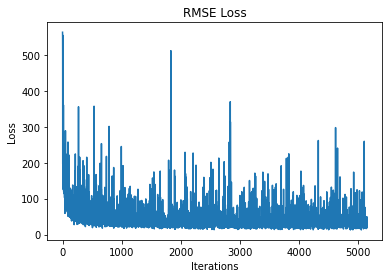

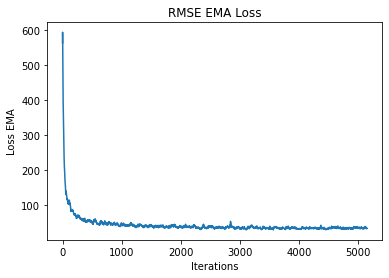

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_array)
plt.title("RMSE Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
plt.plot(loss_ema_array)
plt.title("RMSE EMA Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss EMA")
plt.show()

In [10]:
import csv
import pandas as pd
import numpy as np
import gc

gc.collect()

torch.cuda.empty_cache()

device = "cuda:0"
model = FCModule().to(device)
model.load_state_dict(torch.load("usingSequential"))

filename = "output_test.csv"

def test(model, device, test_loader):
    model.eval()
    store = [[]]
    strArr = []
    strArr.append('ID')
    for i in range(60):
        strArr.append('v' + str(i + 1))
    

    with torch.no_grad():
        for scene_idx, data in test_loader:
            data = data.to(device)
            y_pred = model(data.reshape(len(data),-1)).reshape(-1,60,30,4)
            y_pred = y_pred[-1,0,:,0:2]
            y_pred = y_pred.cpu()
            y_pred_np = y_pred.numpy()
            y_pred_np = y_pred_np.flatten()
            y_pred_np = np.insert(y_pred_np, 0, scene_idx[0][0][0][0])
            store.append(y_pred_np)
            
            

    with open(filename, 'w',  newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(strArr) 
        csvwriter.writerows(store)

test(model, device, test_loader)

In [11]:
import pandas as pd

file = pd.read_csv('output_test.csv')

file["ID"] = file["ID"].astype('int32')

file.to_csv(path_or_buf="./output_test.csv", header=True, index=False)